In [3]:
!pip3 install torch
!pip3 install tqdm
!pip3 install nltk
!pip3 install pandas
!pip3 install numpy
!apt-get install wget

     |████████████████████████████████| 734.6MB 43kB/s s eta 0:00:01     |████████████████████████████▉   | 662.1MB 10.6MB/s eta 0:00:07     |█████████████████████████████▌  | 676.1MB 11.0MB/s eta 0:00:06
     |████████████████████████████████| 61kB 1.0MB/s eta 0:00:011
     |████████████████████████████████| 1.5MB 1.0MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1450715 sha256=7b70356c348a940b78bcec37c598a65d19b2201575b3b77390a18fc53427ccd4
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
     |████████████████████████████████| 10.4MB 6.8MB/s eta 0:00:01
     |████████████████████████████████| 512kB 12.0MB/s eta 0:00:01


In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm.auto import tqdm

from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm.auto import tqdm

import pandas as pd

import numpy as np

from torch.utils.data import Dataset, DataLoader

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
from google.colab import files
files.upload()

Saving ctx_quest.csv to ctx_quest.csv


In [0]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
# !gzip -d cc.ru.300.vec.gz

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2019-12-06 16:50:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-06 16:50:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-06 16:50:17--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [17]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
device

True


device(type='cuda')

In [19]:
df = pd.read_csv("ctx_quest.csv")
df.head()

,Unnamed: 0,context,question
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?
1,1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...
2,2,"Managed by her father, Mathew Knowles, the gro...",When did Beyonce leave Destiny's Child and bec...
3,3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?
4,4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?


In [20]:
# потом можете добавить свою предобработку

def process_text(text):
    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [21]:
all_text_data = []
all_text_data.extend(list(df['context']))
all_text_data.extend(list(df['question']))
all_text_data = list(set(all_text_data))
cleaned_text_data = [x for x in all_text_data if 'float' not in str(type(x))]
cleaned_text_data[:2]

['What did Pere and Devo draw inspiration for their music from?',
 'What was seen as "infantile" in the United States?']

In [22]:
'float' in str(type(cleaned_text_data[0]))

False

In [23]:
word2freq = {}
lengths = []

for text in tqdm(cleaned_text_data):
  
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

In [24]:
len(word2freq)

80148

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

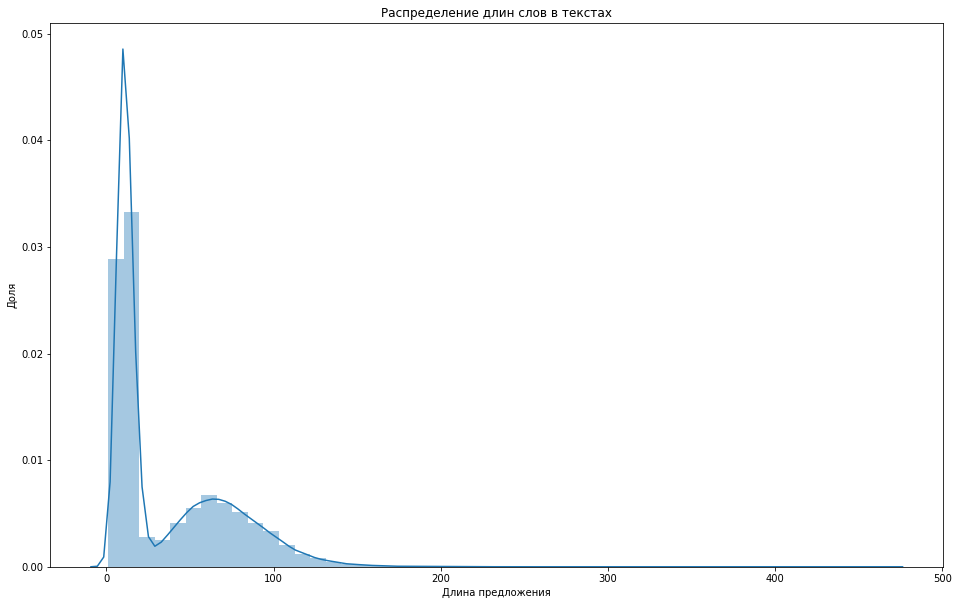

In [16]:

plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [26]:
print(len(lengths)*0.25)
print(len(lengths)*0.75)
sorted(lengths)[36213] , sorted(lengths)[108641] 

36213.75
108641.25


(10, 62)

In [27]:
upper_threshold = 80
lower_threshold = 10

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'66.57 % наших текстов входят в промежуток от 10 до 80 слов'

In [28]:
SENTENCE_LENGTH = 80
QUESTION_LENGTH = 20

In [29]:
with open("glove.6B.50d.txt", "r") as lines:
    for line in lines:
      print(line.split()[0], line.split()[0] in word2freq, len(line.split()[1:]))
      print(line.split()[1:])
      break
    
    # w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
    #        for line in lines}

the True 50
['0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581']


In [0]:
# import numpy as np

# with open("glove.6B.50d.txt", "rb") as lines:
#     w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#            for line in lines}

In [30]:
word2index = {'PAD': 0}
vectors = []
    
# word2vec_file = open('cc.ru.300.vec')
with open("glove.6B.50d.txt", "r") as lines:
    
    # n_words, embedding_dim = word2vec_file.readline().split()
    # n_words, embedding_dim = int(n_words), int(embedding_dim)
    embedding_dim = 50
    # Zero vector for PAD
    vectors.append(np.zeros((1, embedding_dim)))
    progress_bar = tqdm(desc='Read word2vec', total=400000)

    # while True:

    #     line = word2vec_file.readline().strip()

    #     if not line:
    #         break
            
        # current_parts = line.split()

        # current_word = ' '.join(current_parts[:-embedding_dim])
    for line in lines:
        current_word = line.split()[0]
        if current_word in word2freq:

            word2index[current_word] = len(word2index)

            # current_vectors = current_parts[-embedding_dim:]
            current_vectors = line.split()[1:]
            current_vectors = np.array(list(map(float, current_vectors)))
            current_vectors = np.expand_dims(current_vectors, 0)

            vectors.append(current_vectors)

        progress_bar.update(1)

    progress_bar.close()

    # word2vec_file.close()

    vectors = np.concatenate(vectors)

vectors = torch.FloatTensor(vectors, device = device)

In [31]:
len(word2index), len(word2freq)

(64902, 80148)

In [32]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 1.31 % слов в датасете
Количество неизвестных слов 15247 из 80148, то есть 19.02 % уникальных слов в словаре
В среднем каждое встречается 4.49 раз

Топ 5 невошедших слов:
), с количеством вхождениий - 8360
). с количеством вхождениий - 6262
". с количеством вхождениий - 2903
", с количеством вхождениий - 2574
." с количеством вхождениий - 2351


In [33]:
class WordData(Dataset):
    
    def __init__(self, ctx_quest_pairs_list , word2index, context_sequence_length=80, 
                 question_sequence_length = 20, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = []
        
        self.word2index = word2index
        self.context_sequence_length = context_sequence_length
        self.question_sequence_length = question_sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(ctx_quest_pairs_list, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        
        # Место для вашей предобработки
    
        words = wordpunct_tokenize(text.lower())

        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for ctx_quest_pair in data_iterator:
            ctx = ctx_quest_pair[0]
            quest = ctx_quest_pair[1]

            ctx = self.process_text(ctx)
            indexed_ctx = self.indexing(ctx)
            self.x_data.append(indexed_ctx)

            quest = self.process_text(quest)
            indexed_quest = self.indexing(quest)
            self.y_data.append(indexed_quest)
    
    def indexing(self, tokenized_text):
        indexes = []
        for word in tokenized_text:
          if word in self.word2index:
            indexes.append(self.word2index[word])
        return indexes
    
    def padding(self, sequence, sequence_type):
        if sequence_type == 'context':
          sequence_length = self.context_sequence_length
        elif sequence_type == "question":
          sequence_length = self.question_sequence_length
        else:
          raise "unkown sequence type"
        count = 0 
        paded_seq = []
        for seq_el in sequence:
          paded_seq.append(seq_el)
          count += 1
          if count >= sequence_length: break
        if count < sequence_length:
          for ind in range (count, sequence_length):
            paded_seq.append(self.pad_index)

        return paded_seq
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x, "context")
        x = torch.Tensor(x).long()

        y = self.y_data[idx]
        y = self.padding(y, "question")
        y = torch.Tensor(y).long()
        
        return x, y

In [34]:
cont_answer_pairs = []
for ctx, quest in zip(list(df['context']), list(df['question'])):
  if 'float' in str(type(ctx)) or 'float' in str(type(quest)):
    continue
  else:
    cont_answer_pairs.append((ctx, quest))
len(cont_answer_pairs), cont_answer_pairs[0]

(86610,
 ("Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
  'When did Beyonce start becoming popular?'))

In [35]:
dataset = WordData(cont_answer_pairs, word2index)

In [36]:
dataset.__getitem__(0)

(tensor([33972, 33404, 16932,    11,  3127,   270,  8242,    11, 36992,    11,
           200,    24,    23,   375,   437,   405,     2,  2852,    24,    14,
            28,   137,  2195,     2,  9315,     2,   380,  1913,     6,  2844,
             3,   375,     6,  1059,     7,  1971,     2,   736,     2,    66,
          1767,     7,   904,  4027,     6,  5264,  5557,    19,     8,   951,
             2,     6,   480,     5,  3101,     7,     1,   284,  2222,    19,
           406,  2195,     4,  1886,  1146,  1535,  1728,    11,   126,  9697,
            56,  1513,   951,     3,  1743,    21,    69,   623,     2, 23818]),
 tensor([   60,   116, 25922,   460,  1642,   803,   185,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]))

In [37]:
data_loader = DataLoader(dataset, batch_size=64)
for x, y in data_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 80]) torch.Size([64, 20])


In [38]:
SOS_token = 0
EOS_token = 1

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, dropout_p=0.1, max_length=QUESTION_LENGTH, vectors=vectors):#output_size
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
#         self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.vectors = vectors
        self.vocab_size, self.embedding_dim = vectors.shape
        # self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(vectors, device = device))
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(self.vectors))
#         self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, 80)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
#         self.out = nn.Linear(self.hidden_size, self.output_size)
        self.out = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, input, hidden, encoder_outputs, debug = False):
#         embedded = self.embedding(input).view(1, 1, -1)
        if debug == True: 
            print("==forward_decoding_cycle===")
            print("input.shape", input.shape)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        if debug == True: print("embedded[0].shape {}, hidden.shape {}".format(embedded[0].shape, hidden.shape))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden), 1)), dim=1)
        if debug == True: 
            print("attn_weights.shape",attn_weights.shape,"encoder_outputs.shape", encoder_outputs.shape)
            print("attn_weights.unsqueeze(0).shape",attn_weights.unsqueeze(0).shape,"encoder_outputs.unsqueeze(0).shape", encoder_outputs.unsqueeze(0).shape)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        hidden = hidden.unsqueeze(0)
        
        output = F.relu(output)
        if debug == True: 
            print("output.shape {}, hidden.shape {}".format(output.shape,hidden.shape ))
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        hidden = hidden.squeeze(1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [39]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, vectors=vectors):#input_size
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vectors = vectors

        self.vocab_size, self.embedding_dim = vectors.shape
        # self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(self.vectors, device = device))
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(self.vectors))
        # self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True)

    def forward(self, input, hidden, debug = False):
        if debug == True: 
            print("====ENCODING_FORWARD====")
            print("input.shape", input.shape)
#         embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.embedding(input)
        output = embedded
        if debug == True: 
            print("embedded/output.shape",embedded.shape,"hidden.shape", hidden.shape  )
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 64, self.hidden_size, device=device)

In [40]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, vectors):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vectors = vectors
        self.vocab_size, self.embedding_dim = vectors.shape
        # self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(self.vectors))
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, self.vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, debug = False):
        if debug == True:
          print("===FORWARD_DECODER===")
          print("input.shape {}, hidden.shape {}".format(input.shape,hidden.shape ))
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [41]:
SENTENCE_LENGTH

80

In [49]:
teacher_forcing_ratio = 0.5

def train_easy(input_tensor, target_batch_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, ctx_len =SENTENCE_LENGTH, 
          debug = False):
    if debug == True: print("target_batch_tensor.shape {}".format(target_batch_tensor.shape))
    

    input_length = input_tensor.size(0)
    target_length = target_batch_tensor.size(1)
    if debug == True: print("target_length", target_length)

#     encoder_outputs = torch.zeros(ctx_len, encoder.hidden_size, device=device)
#     print("encoder_outputs.shape", encoder_outputs.shape)
  
    
#     print("input_length is", input_length)
    encoder_hidden = encoder.initHidden()
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
#     for ei in range(input_length):
# #         print("ei", ei)
#         print("input_tensor[ei].shape",input_tensor[ei].shape, "encoder_hidden.shape", encoder_hidden.shape)
#         encoder_output, encoder_hidden = encoder(
#             input_tensor[ei], encoder_hidden)
#         encoder_outputs[ei] = encoder_output[0, 0]
    if debug == True: print("AFTER_ENCODING , encoder_output.shape{}, encoder_hidden.shape{}".format(encoder_output.shape, encoder_hidden.shape))
    
    for batch_element_index in range(64):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss = 0
        target_tensor = target_batch_tensor[batch_element_index, :]
        if debug == True: 
            print("target_tensor.shape {}, target_tensor {}".format(target_tensor.shape, target_tensor))
#         target_tensor = target_tensor.unsqueeze(-1)
#         print("target_tensor.shape {} after unsqueeze".format(target_tensor.shape))
        
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden[:,batch_element_index,:].unsqueeze(1)
        
        # encoder_outputs = encoder_output[batch_element_index,:,:]
        if debug == True: 
            print("go_to_decoder_with decoder_input{}, decoder_hidden.shape {}".format(decoder_input, decoder_hidden.shape))

#         use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        # Teacher forcing: Feed the target as the next input
        
        for di in range(target_length):
            if debug == True: 
                print("iterate_over_target {}th time, decoder_input.shape {}".format(di, decoder_input.shape))
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            if debug == True: 
                print("AFTER_DECODER_STEP decoder_output.shape {}, decoder_input.shape {}, decoder_input {}".format(decoder_output.shape, decoder_input.shape, decoder_input))
#                 decoder_input = torch.tensor([decoder_input], device=device)
            target_word = torch.tensor([target_tensor[di]], device=device)
            loss += criterion(decoder_output, target_word)
            # print("loss", loss)
            decoder_input = torch.tensor([target_tensor[di]], device=device).unsqueeze(1)  # Teacher forcing
#                 decoder_input = target_tensor[di]

        loss.backward(retain_graph=True)
        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item() / target_length

In [43]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [53]:
for input_tensor, target_tensor in data_loader:
    print(input_tensor.shape,target_tensor.shape )
    break

torch.Size([64, 80]) torch.Size([64, 20])


In [60]:
def trainIters_loader(encoder, decoder, epochs = 5, learning_rate=0.01, total_items = len(cont_answer_pairs), debug = False):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = []
    criterion = nn.NLLLoss()
    losses = []
    for n_epoch in range(epochs):
      progress_bar = tqdm(total=total_items, desc='Epoch {}'.format(n_epoch + 1))
      for input_tensor, target_tensor in data_loader:
            try:
                input_tensor = input_tensor.to(device)
                target_tensor = target_tensor.to(device)
                if debug == True:print("input_tensor.shape", input_tensor.shape, "target_tensor.shape", target_tensor.shape)
                loss = train_easy(input_tensor, target_tensor, encoder,
                          decoder, encoder_optimizer, decoder_optimizer, criterion)
                losses.append(loss)
                progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))
    #             print("should_update_by {}".format(input_tensor.shape[0]))
                progress_bar.update(input_tensor.shape[0])
                print_loss_total += loss
              # plot_loss_total += loss

              # if iter % print_every == 0:
              #     print_loss_avg = print_loss_total / print_every
              #     print_loss_total = 0
              #     print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
              #                                 iter, iter / n_iters * 100, print_loss_avg))
              #     # evaluateRandomly(encoder, decoder, n = 5)
              # if iter % plot_every == 0:
              #     plot_loss_avg = plot_loss_total / plot_every
              #     plot_losses.append(plot_loss_avg)
              #     plot_loss_total = 0
              #     showPlot(plot_losses)
            except:
                print("smth_wrong_with_tensors", input_tensor.shape, target_tensor.shape)
    print_loss_avg = print_loss_total / total_items
    # tqdm.write('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    tqdm.write('Losses: train - {:.3f}'.format(print_loss_avg))

In [45]:
device

device(type='cuda')

In [ ]:
hidden_size = 50
# 37487
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
encoder1 = EncoderRNN(hidden_size)
encoder1.to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, max_length = MAX_LENGTH, dropout_p=0.1).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, dropout_p=0.1)
attn_decoder1 = DecoderRNN(hidden_size, vectors)
attn_decoder1.to(device)



In [ ]:
trainIters_loader(encoder1, attn_decoder1)

smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])
smth_wrong_with_tensors torch.Size([64, 80]) torch.Size([64, 20])


In [59]:
torch.save(attn_decoder1, "Decoder")


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
torch.save(encoder1, "Encoder")


In [ ]:
trainIters_loader(encoder1, attn_decoder1)

In [ ]:
trainIters_loader(encoder1, attn_decoder1)

In [ ]:
trainIters_loader(encoder1, attn_decoder1)

In [0]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_batch_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, ctx_len =SENTENCE_LENGTH, 
          debug = False):
    
    if debug == True: print("target_batch_tensor.shape {}".format(target_batch_tensor.shape))
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_batch_tensor.size(1)
    if debug == True: print("target_length", target_length)

#     encoder_outputs = torch.zeros(ctx_len, encoder.hidden_size, device=device)
#     print("encoder_outputs.shape", encoder_outputs.shape)
  
    loss = 0
#     print("input_length is", input_length)
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
#     for ei in range(input_length):
# #         print("ei", ei)
#         print("input_tensor[ei].shape",input_tensor[ei].shape, "encoder_hidden.shape", encoder_hidden.shape)
#         encoder_output, encoder_hidden = encoder(
#             input_tensor[ei], encoder_hidden)
#         encoder_outputs[ei] = encoder_output[0, 0]
    if debug == True: print("AFTER_ENCODING , encoder_output.shape{}, encoder_hidden.shape{}".format(encoder_output.shape, encoder_hidden.shape))
    
    for batch_element_index in range(64):
        target_tensor = target_batch_tensor[batch_element_index, :]
        if debug == True: 
            print("target_tensor.shape {}, target_tensor {}".format(target_tensor.shape, target_tensor))
#         target_tensor = target_tensor.unsqueeze(-1)
#         print("target_tensor.shape {} after unsqueeze".format(target_tensor.shape))
        
        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden[:,batch_element_index,:]
        
        encoder_outputs = encoder_output[batch_element_index,:,:]
        if debug == True: print("go_to_decoder_with decoder_input{}, decoder_hidden.shape {}, encoder_outputs.shape{}".format(decoder_input, decoder_hidden.shape, encoder_outputs.shape))

#         use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        use_teacher_forcing = True
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                if debug == True: 
                    print("iterate_over_target {}th time, decoder_input.shape {}".format(di, decoder_input.shape))
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                if debug == True: 
                    print("AFTER_DECODER_STEP decoder_output.shape {}, decoder_input.shape {}, decoder_input {}".format(decoder_output.shape, decoder_input.shape, decoder_input))
#                 decoder_input = torch.tensor([decoder_input], device=device)
                target_word = torch.tensor([target_tensor[di]], device=device)
                loss += criterion(decoder_output, target_word)
                if debug == True: print("loss", loss)
                decoder_input = torch.tensor([target_tensor[di]], device=device).unsqueeze(1)  # Teacher forcing
#                 decoder_input = target_tensor[di]

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

        loss.backward(retain_graph=True)
        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length, device=device)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

NameError: name 'MAX_LENGTH' is not defined

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
device

device(type='cpu')

In [0]:
evaluateRandomly(encoder1, attn_decoder1)

> the cemetery originated when the englishman mr . thomas samuel hood purchased a plot of land in the name of the english residents in .
= when did mr . thomas samuel hood purchase a plot of land at the british cemetery montevideo ?
< when did the did of the ? ? ? ? <EOS>

> asphalt emulsions contain up to asphalt bitumen and typically less than . chemical additives .
= what percentage of bitumen is found in bitumen water emulsions ?
< what do the for for the ? <EOS>

> according to the china national space administration the development of the system would be carried out in three steps 
= the china national space administration said the satellite navigation system would be developed in how many steps ?
< what many the the of the the <EOS>

> duplications play a major role in shaping the genome .
= what type of generation of genetic material has a big part in making the genome what it is ?
< what type of a the the <EOS>

>  an example of a perdurantist is david lewis . 
= who is an exa